# MLP staged fitting by batch (instead of epochs)

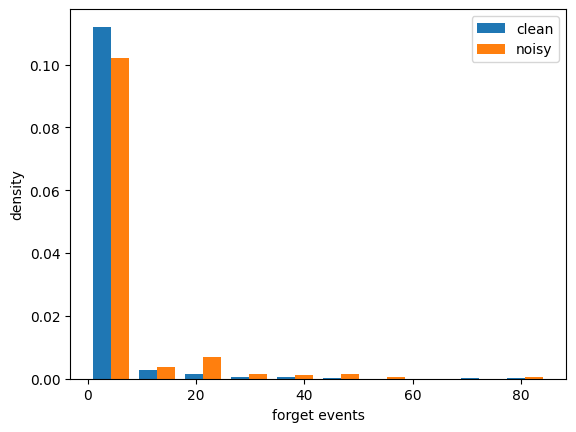

In [6]:
import os
from functools import partial

import matplotlib.pyplot as plt
import numpy as np
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.neural_network import MLPClassifier
from sklearn.utils import gen_batches, shuffle

from mislabeled.datasets.wrench import fetch_wrench
from mislabeled.detect.detectors import ForgetScores
from mislabeled.ensemble._progressive import staged_fit
from mislabeled.preprocessing import WeakLabelEncoder

seed = 1
fetch_wrench = partial(
    fetch_wrench, cache_folder=os.path.join(os.path.expanduser("~"), "datasets")
)
dataset = "youtube"
all = fetch_wrench(dataset)
train = fetch_wrench(dataset, split="train")
validation = fetch_wrench(dataset, split="validation")
test = fetch_wrench(dataset, split="test")

tfidf = TfidfVectorizer(
    strip_accents="unicode", stop_words="english", min_df=2, max_df=1.0
).fit(all["data"])

X_train = tfidf.transform(train["data"]).astype(np.float32)
X_validation = tfidf.transform(validation["data"]).astype(np.float32)
X_test = tfidf.transform(test["data"]).astype(np.float32)

y_train = train["target"]
y_validation = validation["target"]
y_test = test["target"]

wle = WeakLabelEncoder(random_state=seed).fit(train["weak_targets"])
y_noisy_train = wle.transform(train["weak_targets"])
y_noisy_validation = wle.transform(validation["weak_targets"])
y_noisy_test = wle.transform(test["weak_targets"])

unlabeled = y_noisy_train == -1
X_train = X_train[~unlabeled]
y_train = y_train[~unlabeled]
y_noisy_train = y_noisy_train[~unlabeled]


@staged_fit.register(MLPClassifier)
def batched_staged_fit_mlp(estimator: MLPClassifier, X, y):
    n_samples = X.shape[0]
    classes = np.unique(y)
    n_iter = estimator.get_params()["max_iter"]
    batch_size = estimator.get_params()["batch_size"]
    for i in range(n_iter):
        X_shuffle, y_shuffle = shuffle(X, y)
        batches = gen_batches(n_samples, batch_size, min_batch_size=batch_size)
        for batch in batches:
            estimator.partial_fit(X_shuffle[batch], y_shuffle[batch], classes=classes)
            yield estimator


forget_mlp = ForgetScores(
    MLPClassifier(
        hidden_layer_sizes=(120),
        solver="sgd",
        learning_rate_init=0.05,
        learning_rate="constant",
        momentum=0.5,
        nesterovs_momentum=True,
        batch_size=100,
        max_iter=100,
    )
)
forget_events = -forget_mlp.trust_score(X_train, y_train)


plt.hist(
    [forget_events[y_train == y_noisy_train], forget_events[y_train != y_noisy_train]],
    label=["clean","noisy"],
    density=True,
)
plt.xlabel("forget events")
plt.ylabel("density")
plt.legend()
plt.show()